In [14]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

solver = CloudPointSolver(
    model = [1, 100, 100, 100, 1],
    optimizer = "adam"
    )

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx + torch.pi * torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num

bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num

T_iter = 3
epoch_per_iter = 1000

x_all = []
y_all = []

for T_id in range(T_iter):
    ## define a pde
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 +0.2

    pde_input = D1Field([t_span_start, t_span_end]).get_field_rand(pde_epoch_size)
    pde_output = np.zeros([pde_epoch_size,1])

    ## define a bc
    bc_input = np.array([[t_span_start]])
    bc_output = np.array(1.).reshape([bc_epoch_size ,1])
    if T_id != 0:
        bc_output[0] = last_flame_data
    
    solver = CloudPointSolver(
        [[pde_input, pde_output],[bc_input, bc_output]],
        [pde_loss,data_loss],
        model = [1, 100, 100, 100, 1],
        optimizer = "adam",
        batchsize = [pde_batch_size,bc_batch_size])

    for epoch_local_id in range(epoch_per_iter):
        epoch_id = T_id * epoch_per_iter + epoch_local_id
        solver.train_step()
        if epoch_local_id % 100 == 0:
            solver.test_step(print_flag=True)

    x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
    y_cpu = solver.model_eval(x_cpu)
    
    last_flame_data = solver.model_eval([[t_span_start + 2]]).item()
    print(last_flame_data)

    if T_id == 0:
        x_all = x_cpu
        y_all = y_cpu
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_all = np.vstack([y_all,y_cpu])


loss is [4.8813334  0.72001094 5.601344  ]
loss is [1.1034092e-02 5.7844431e-07 1.1034670e-02]
loss is [2.2883369e-03 3.0384763e-07 2.2886407e-03]
loss is [1.5422308e-03 2.1261462e-07 1.5424434e-03]
loss is [1.0849535e-03 1.0130776e-07 1.0850548e-03]
loss is [8.1450550e-04 4.9005408e-08 8.1455451e-04]
loss is [6.2807021e-04 2.5746033e-08 6.2809594e-04]
loss is [4.6052755e-04 1.6514207e-08 4.6054405e-04]
loss is [3.0271622e-04 1.1871691e-08 3.0272809e-04]
loss is [1.7283832e-04 8.6680672e-09 1.7284699e-04]
1.1010377407073975
loss is [4.6516705 0.5681394 5.21981  ]
loss is [1.2710265  0.00183585 1.2728623 ]
loss is [3.8657159e-02 2.7297539e-05 3.8684458e-02]
loss is [4.8026545e-03 9.8773353e-07 4.8036422e-03]
loss is [2.4432811e-04 6.1481842e-08 2.4438958e-04]
loss is [8.4550193e-05 1.6483582e-08 8.4566673e-05]
loss is [5.3827407e-05 8.6237293e-07 5.4689779e-05]
loss is [1.6132915e-05 2.2284894e-09 1.6135144e-05]
loss is [5.5215416e-05 4.0964437e-07 5.5625060e-05]
loss is [5.519074e-06 9

total error 0.08614420349335639
[[5.1585593e+00 3.5424900e-01 5.5128083e+00]
 [4.4972081e+00 5.9896038e-08 4.4972081e+00]
 [2.9946039e+00 3.1602476e-04 2.9949200e+00]
 [2.1599779e-01 6.1789986e-05 2.1605958e-01]
 [1.2852255e-02 3.1456420e-06 1.2855401e-02]
 [5.3553628e-03 1.4447734e-06 5.3568077e-03]
 [2.5620742e-03 9.7874988e-07 2.5630530e-03]
 [1.1719144e-03 1.1731827e-06 1.1730876e-03]
 [3.1042574e-03 6.1290608e-05 3.1655480e-03]
 [5.5307627e-04 4.6345504e-06 5.5771082e-04]]


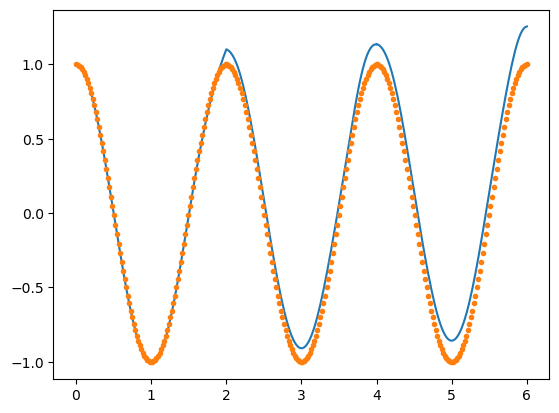

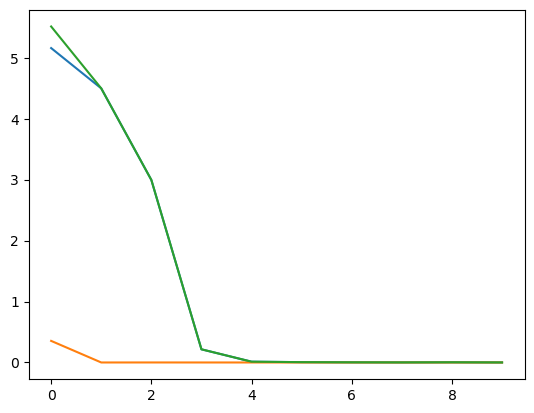

In [15]:

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_all,y_all)
y_all_real = np.cos(np.pi*np.array(x_all))
ax.plot(np.array(x_all), y_all_real,'.')
y_all_real = np.cos(np.pi*np.array(x_all))
print('total error', np.mean(np.abs(np.array(y_all_real)-np.array(y_all))) )
test_log = solver.get_logger()
test_log_np = np.array(test_log)

fig,ax = plt.subplots()
plt.plot(test_log_np[:,0])
plt.plot(test_log_np[:,1])
plt.plot(test_log_np[:,2])
print(test_log_np)
